# KNN Regression: California Housing Prices
This notebook implements a K Nearest Neighbor (KNN) regression model to predict house prices using the California Housing dataset. It includes EDA, feature engineering, modeling, and evaluation.

In [65]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import sklearn modules
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Import additonal modules
from math import radians, sin, cos, sqrt, atan2

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style for better visuals
sns.set_style('whitegrid')
%matplotlib inline

# Define project root and images directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
IMAGES_DIR = os.path.join(PROJECT_ROOT, 'images')

# Verify libraries are loaded
print("All libraries loaded correctly")

All libraries loaded correctly


## 1. Data Loading
Load the California Housing dataset and convert it to a Pandas DataFrame.

In [66]:
# Load dataset
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target

# Display first few rows
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 2. Exploratory Data Analysis
Summarize features, check for missing values, and identify outliers.

In [67]:
# Basic statistics
print("Summary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print("\nOutliers per Feature:")
print(outliers)

Summary Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0

### 2.1 Feature Distributions
Visualize feature distributions to check for skewness and scaling needs.

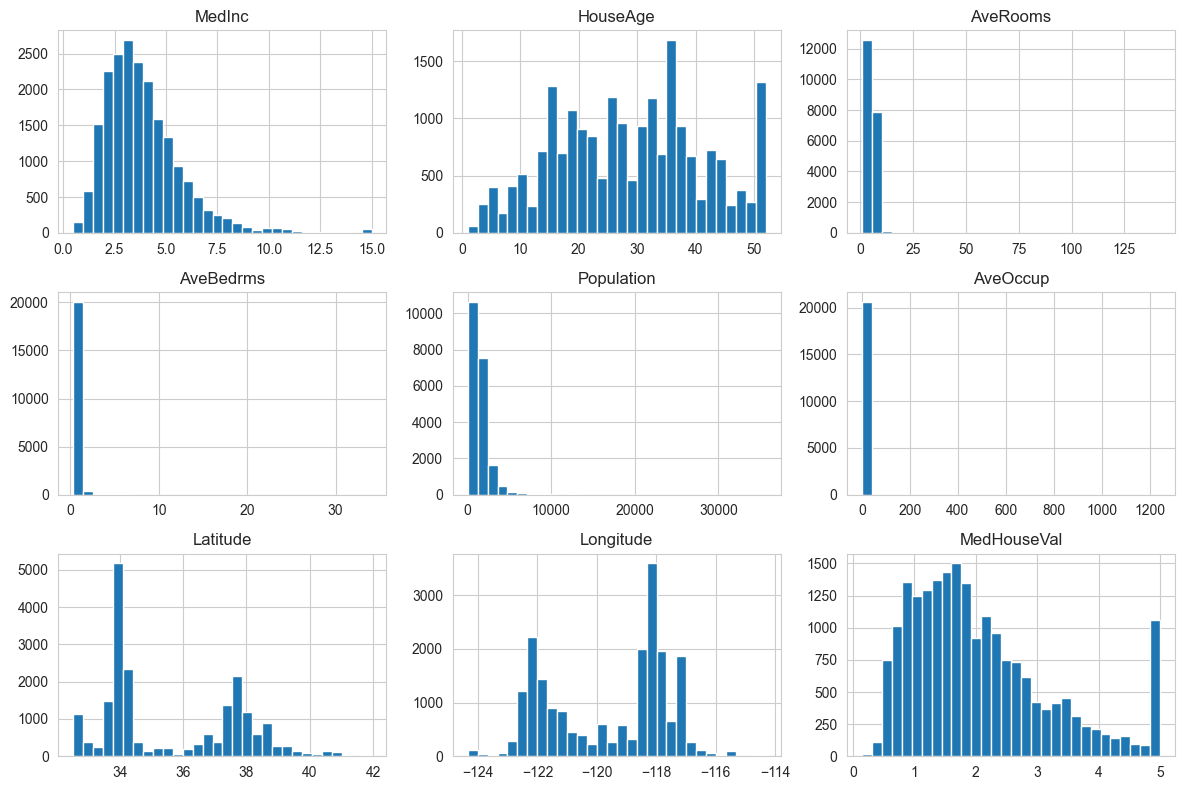

In [68]:
# Plot histograms for all features
df.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'feature_histograms.png'), dpi=300, bbox_inches='tight')
plt.show()

### 2.2 Feature Relationships
Explore correlations and scatter plots to identify strong predictors.

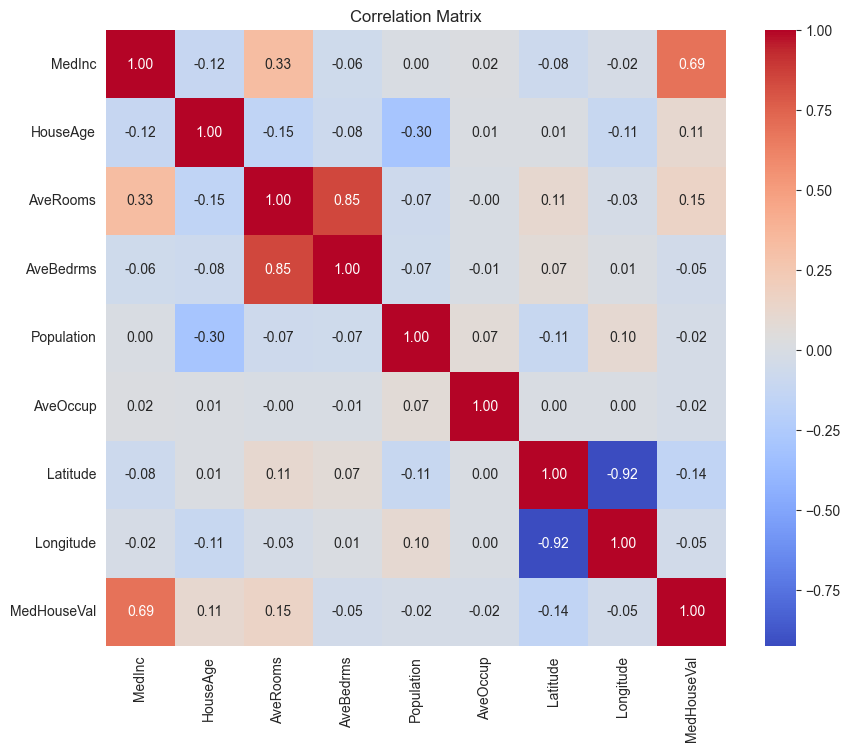

In [69]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig(os.path.join(IMAGES_DIR, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

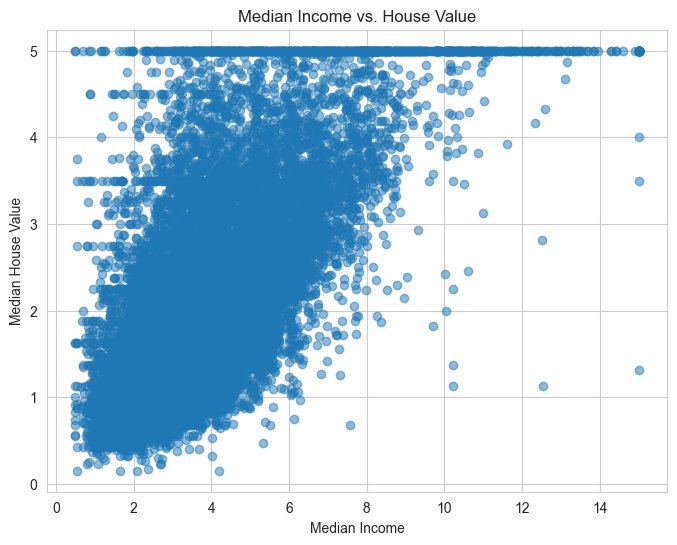

In [70]:
# Scatter plot: MedInc vs. MedHouseVal
plt.figure(figsize=(8, 6))
plt.scatter(df['MedInc'], df['MedHouseVal'], alpha=0.5)
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.title('Median Income vs. House Value')
plt.savefig(os.path.join(IMAGES_DIR, 'medinc_vs_houseval.png'), dpi=300, bbox_inches='tight')
plt.show()

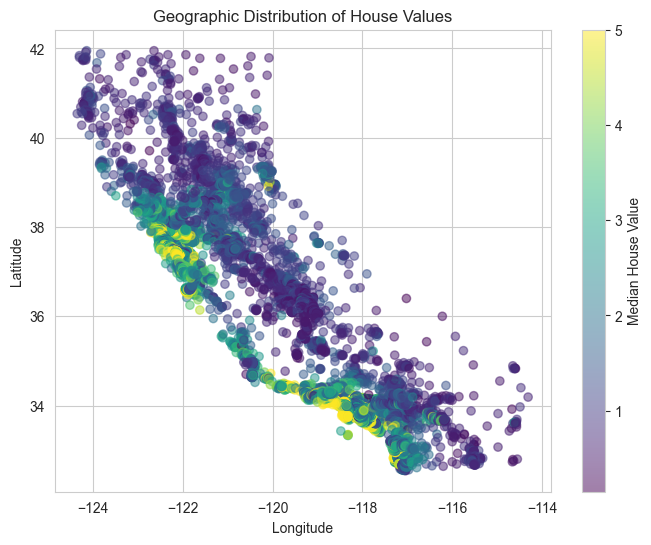

In [71]:
# Geographic scatter plot: Latitude vs. Longitude
plt.figure(figsize=(8, 6))
plt.scatter(df['Longitude'], df['Latitude'], c=df['MedHouseVal'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of House Values')
plt.savefig(os.path.join(IMAGES_DIR, 'geographic_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

## 3. Data Preprocessing
Prepare the dataset for KNN by splitting data, handling outliers, and scaling features.

In [72]:
# Define features (X) and target (y)
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (16512, 8) (16512,)
Test set shape: (4128, 8) (4128,)


### 3.1 Outlier Handling
Cap outliers using the IQR method to reduce their impact on KNN distances.

In [73]:
# Cap outliers in specified columns using IQR method
def cap_outliers(df, columns):
    """Cap outliers in specified columns using IQR method."""
    df_capped = df.copy()
    for col in columns:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
    return df_capped

# Cap outliers in training set for features with significant outliers
outlier_columns = ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']
X_train_capped = cap_outliers(X_train, outlier_columns)

# Apply same capping to test set (using training set bounds to avoid data leakage)
X_test_capped = cap_outliers(X_test, outlier_columns)

print("Outliers capped in:", outlier_columns)

Outliers capped in: ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']


### 3.2 Feature Scaling
Standardize features to ensure equal contribution to KNN distance calculations.

In [74]:
# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data and transform
X_train_scaled = scaler.fit_transform(X_train_capped)
X_test_scaled = scaler.transform(X_test_capped)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Scaled training data sample:")
X_train_scaled.head()

Scaled training data sample:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,-0.326196,0.348490,-0.237383,-0.645567,1.257726,1.149541,-1.372811,1.272587
1,-0.035843,1.618118,-0.673852,-0.217580,-0.031355,-1.679346,-0.876696,0.709162
2,0.144701,-1.952710,0.266522,-0.909173,-0.553001,-0.252943,-0.460146,-0.447603
3,-1.017864,0.586545,-1.051455,-0.306710,0.104613,1.587622,-1.382172,1.232698
4,-0.171488,1.142008,0.765942,0.935838,-0.606604,-0.865736,0.532084,-0.108551


### 3.3 Feature Engineering
Create polynomial features and distance-based features to capture non-linear and spatial patterns.

In [75]:
# Polynomial features for key predictors
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_train_scaled[['MedInc', 'AveRooms']])
poly_columns = poly.get_feature_names_out(['MedInc', 'AveRooms'])
X_train_poly = pd.DataFrame(poly_features, columns=poly_columns, index=X_train_scaled.index)
X_train_scaled = pd.concat([X_train_scaled, X_train_poly], axis=1)

# Apply to test set
poly_features_test = poly.transform(X_test_scaled[['MedInc', 'AveRooms']])
X_test_poly = pd.DataFrame(poly_features_test, columns=poly_columns, index=X_test_scaled.index)
X_test_scaled = pd.concat([X_test_scaled, X_test_poly], axis=1)

# Distance to major city (e.g., San Francisco: 37.7749°N, -122.4194°W)
def haversine_distance(lat1, lon1, lat2=-122.4194, lon2=37.7749):
    """Calculate Haversine distance between two points in miles."""
    R = 3958.8  # Earth's radius in miles
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Add distance to San Francisco
X_train_scaled['DistToSF'] = X_train_scaled.apply(
    lambda row: haversine_distance(row['Latitude'], row['Longitude']), axis=1
)
X_test_scaled['DistToSF'] = X_test_scaled.apply(
    lambda row: haversine_distance(row['Latitude'], row['Longitude']), axis=1
)

print("New features added:", X_train_scaled.columns.tolist())

New features added: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedInc', 'AveRooms', 'MedInc^2', 'MedInc AveRooms', 'AveRooms^2', 'DistToSF']


### 3.4 Preprocessing Pipeline
Create a pipeline to automate outlier capping, scaling, and feature engineering.

In [76]:
# Custom transformer for outlier capping
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        self.bounds_ = {}
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.bounds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self
    def transform(self, X):
        X_capped = X.copy()
        for col in self.columns:
            lower, upper = self.bounds_[col]
            X_capped[col] = X_capped[col].clip(lower=lower, upper=upper)
        return X_capped

# Define pipeline
preprocessor = Pipeline([
    ('outlier_capper', OutlierCapper(outlier_columns)),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Fit and transform training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert to DataFrame (note: poly features will have generic names)
feature_names = preprocessor.named_steps['poly'].get_feature_names_out(X_train.columns)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names)

print("Preprocessed training data sample:")
X_train_preprocessed.head()

Preprocessed training data sample:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc^2,MedInc HouseAge,...,Population^2,Population AveOccup,Population Latitude,Population Longitude,AveOccup^2,AveOccup Latitude,AveOccup Longitude,Latitude^2,Latitude Longitude,Longitude^2
0,-0.326196,0.348490,-0.237383,-0.645567,1.257726,1.149541,-1.372811,1.272587,0.106404,-0.113676,...,1.581875,1.445808,-1.726621,1.600565,1.321446,-1.578103,1.462891,1.884611,-1.747021,1.619477
1,-0.035843,1.618118,-0.673852,-0.217580,-0.031355,-1.679346,-0.876696,0.709162,0.001285,-0.057999,...,0.000983,0.052656,0.027489,-0.022236,2.820204,1.472276,-1.190929,0.768596,-0.621720,0.502911
2,0.144701,-1.952710,0.266522,-0.909173,-0.553001,-0.252943,-0.460146,-0.447603,0.020939,-0.282560,...,0.305810,0.139878,0.254462,0.247525,0.063980,0.116391,0.113218,0.211735,0.205963,0.200349
3,-1.017864,0.586545,-1.051455,-0.306710,0.104613,1.587622,-1.382172,1.232698,1.036048,-0.597024,...,0.010944,0.166086,-0.144593,0.128956,2.520545,-2.194367,1.957059,1.910399,-1.703801,1.519545
4,-0.171488,1.142008,0.765942,0.935838,-0.606604,-0.865736,0.532084,-0.108551,0.029408,-0.195841,...,0.367968,0.525159,-0.322764,0.065848,0.749499,-0.460644,0.093977,0.283113,-0.057758,0.011783


### 3.5 Visualize Preprocessed Data
Plot distributions of scaled features to verify preprocessing.

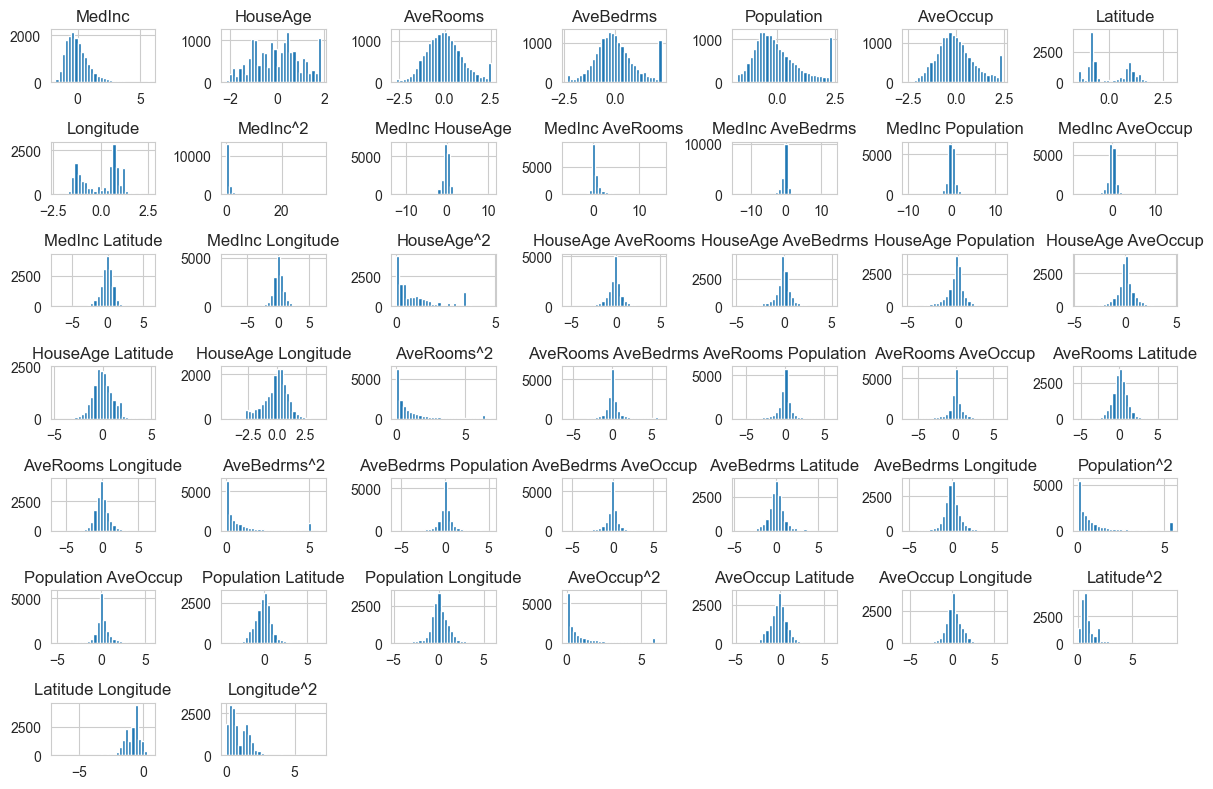

In [77]:
# Plot histograms of preprocessed features
X_train_preprocessed.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'preprocessed_histograms.png'), dpi=300, bbox_inches='tight')
plt.show()